In [ ]:
import keras
from keras.models import Model
from keras.layers import *
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [3]:
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 8

# DATA

### Downloading the Dataset


In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation
!unzip 'brain-tumor-segmentation.zip' -d 'Dataset'

### Loading the Dataset


In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    return tf.cast(tf.image.resize(img, IMAGE_SHAPE[:2]), tf.uint8)

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)
    return tf.cast(tf.image.resize(mask, IMAGE_SHAPE[:2]), tf.uint8)

In [5]:
import os

images_path = os.path.join('Dataset', 'images')
masks_path = os.path.join('Dataset', 'masks')
images = []
for filename in os.listdir(images_path):
  image_path = os.path.join(images_path, filename)
  image = load_image(image_path)
  images.append(image)

masks = []
for filename in os.listdir(masks_path):
  mask_path = os.path.join(masks_path, filename)
  mask = load_mask(mask_path)
  masks.append(mask)

images = np.tile(images, (3, 1, 1, 1))
masks = np.tile(masks, (3, 1, 1, 1))
dataset = tf.data.Dataset.from_tensor_slices((images, masks)).shuffle(3000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
len(dataset)

1149

### Data Augmentation

In [18]:
def build_augmentor():
    seed = 42
    input_img = Input(IMAGE_SHAPE)
    input_mask = Input((IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1))

    img = RandomFlip("horizontal_and_vertical", seed=seed)(input_img)
    mask = RandomFlip("horizontal_and_vertical", seed=seed)(input_mask)

    img = RandomRotation(0.2, seed=seed)(img)
    mask = RandomRotation(0.2, seed=seed)(mask)

    img = RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed)(img)
    mask = RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed)(mask)

    img = RandomContrast(0.2)(img)
    img = RandomBrightness(factor=0.2)(img)
    img = GaussianNoise(0.2)(img)

    img = Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[0])(img)
    out_img = Rescaling(scale=1./255.)(img)

    mask = Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[0])(mask)
    out_mask = Rescaling(scale=1./255.)(mask)

    return Model(inputs=[input_img, input_mask], outputs=[out_img, out_mask])

augmentor = build_augmentor()


def augment(image, mask):
    return augmentor((image, mask))

In [20]:
augmented_dataset = dataset.map(augment)
train = augmented_dataset.take(1000)
test = augmented_dataset.skip(1000)

train, test

(<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

### Testing the Dataset

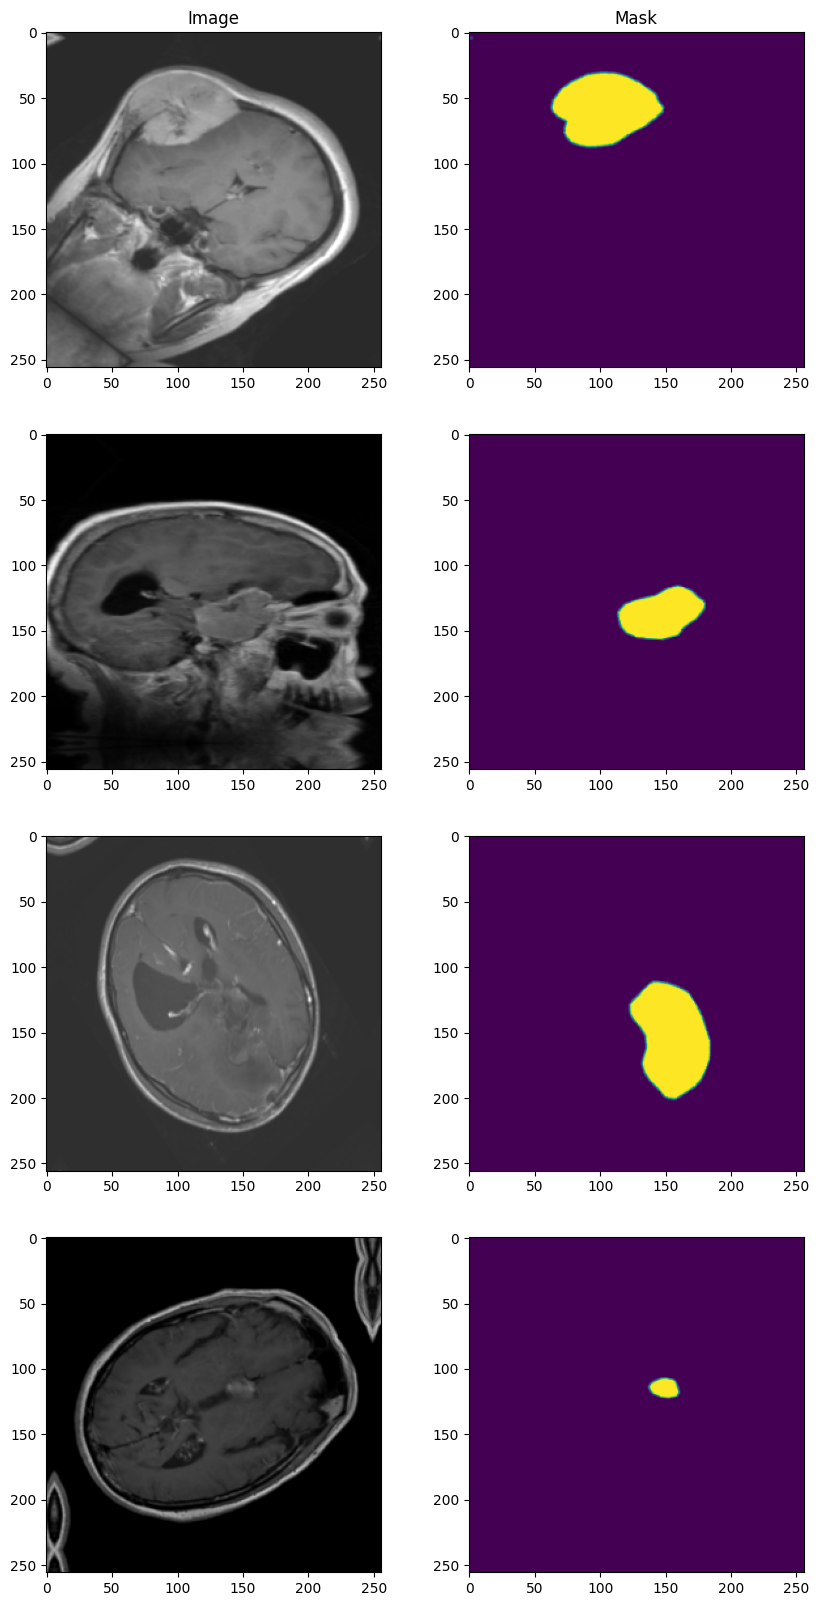

In [21]:
samples = test.as_numpy_iterator().next()

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
ax[0, 0].set_title('Image')
ax[0, 1].set_title('Mask')
for i in range(4):
    ax[i, 0].imshow(tf.cast(samples[0][i]*255., tf.uint8))
    ax[i, 1].imshow(samples[1][i]*255.)

# MODEL

### Building the Model

In [22]:
class Attention_UNet(Model):
    def __init__(self):
        super(Attention_UNet, self).__init__()

        self.model = self.build_model()

    # Attention UNet Model
    def build_model(self):
        def conv_block(filters, input):
            x = Conv2D(filters, 3, padding="same", kernel_initializer = "he_normal")(input)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(filters, 3, padding="same", kernel_initializer = "he_normal")(x)
            x = BatchNormalization()(x)
            return Activation("relu")(x)

        def attention_block(filters, in1, in2):
            x = Conv2D(filters, 1, padding="same")(in1)
            x = BatchNormalization()(x)
            y = Conv2D(filters, 1, padding="same")(in2)
            y = BatchNormalization()(y)
            x = Activation('relu')(x+y)
            x = Conv2D(filters, 1, padding='same')(x)
            x = Activation('sigmoid')(x)
            return in1*x


        inputs = Input(IMAGE_SHAPE)

        # Encoder
        x = conv_block(64, inputs)
        y = MaxPool2D(pool_size=(2, 2))(x)

        y = conv_block(128, y)
        z = MaxPool2D(pool_size=(2, 2))(y)

        z = conv_block(256, z)
        t = MaxPool2D(pool_size=(2, 2))(z)

        t = conv_block(512, t)

        # Decoder
        t = UpSampling2D()(t)
        a = attention_block(256, z, t)
        t = Concatenate()([a, t])

        t = conv_block(256, t)
        t = UpSampling2D()(t)
        a = attention_block(128, y, t)
        t = Concatenate()([a, t])

        t = conv_block(128, t)
        t = UpSampling2D()(t)
        a = attention_block(64, x, t)
        t = Concatenate()([a, t])

        t = conv_block(64, t)
        out = Conv2D(1, 1, padding="same", activation='sigmoid')(t)

        return Model(inputs, out)


    def call(self, inputs):
        return self.model(inputs)


    def save(self, path):
        self.model.save(path)

In [23]:
model = Attention_UNet()
model.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0]

In [24]:
opt = tf.keras.optimizers.Adam(0.0001)

def dice_loss(y_true, y_pred):
    smooth = 1e-15

    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1.0 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth))

model.compile(optimizer=opt, loss=dice_loss, metrics=['accuracy'])

### Training the Model

In [ ]:
model.fit(train, epochs=10, validation_data=test)

### Testing the Model

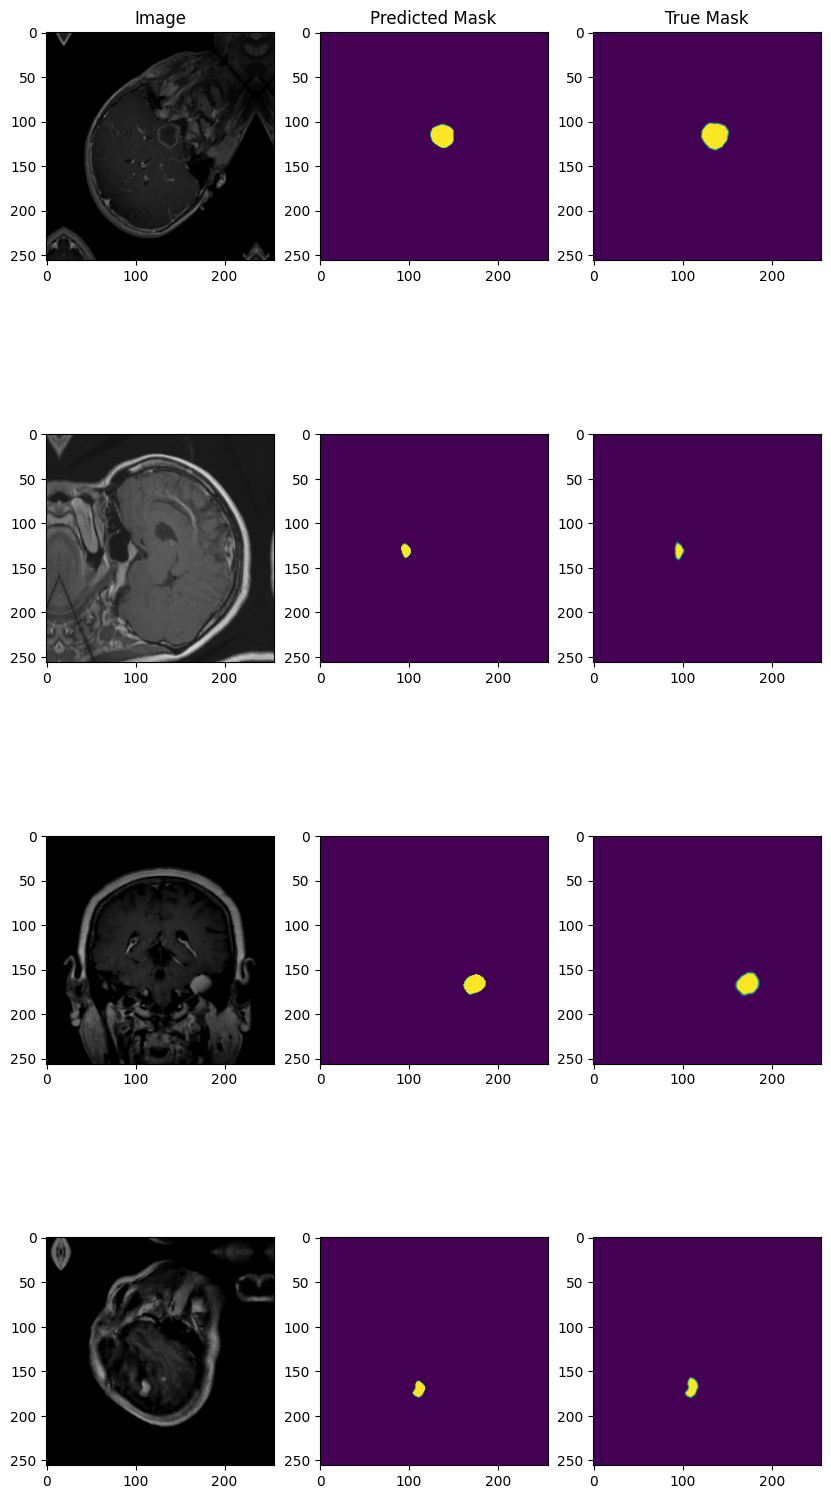

In [34]:
samples = test.as_numpy_iterator().next()

predictions = model(samples[0])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))
ax[0, 0].set_title('Image')
ax[0, 1].set_title('Predicted Mask')
ax[0, 2].set_title('True Mask')
for i in range(4):
    ax[i, 0].imshow(tf.cast(samples[0][i]*255., tf.uint8))
    ax[i, 1].imshow(predictions[i]*255.)
    ax[i, 2].imshow(samples[1][i]*255.)

### Saving the Model

In [37]:
model.save('Attention_UNet.keras')